In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/My Drive/KUIAI/

/content/gdrive/My Drive/KUIAI


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [4]:
label_data = pd.read_csv('04. Dataset_Molding/dataset/labeled_data.csv')

In [5]:
label_data['EQUIP_NAME'].value_counts()

650톤-우진2호기    7992
650톤-우진          2
1800TON-우진       2
Name: EQUIP_NAME, dtype: int64

In [6]:
label_data['PART_NAME'].value_counts()

CN7 W/S SIDE MLD'G RH        3371
CN7 W/S SIDE MLD'G LH        3365
RG3 MOLD'G W/SHLD, LH         628
RG3 MOLD'G W/SHLD, RH         628
SP2 CVR ROOF RACK CTR, RH       2
JX1 W/S SIDE MLD'G RH           2
Name: PART_NAME, dtype: int64

In [7]:
def make_input(data, machine_name, product_name):
    machine_ = data['EQUIP_NAME'] == machine_name
    product_ = data['PART_NAME'] == product_name
    data = data[machine_ & product_]

    data.drop(['_id', 'TimeStamp', 'PART_FACT_PLAN_DATE', 'Reason',
               'PART_FACT_SERIAL', 'PART_NAME', 'EQUIP_CD', 'EQUIP_NAME',
               'Mold_Temperature_1', 'Mold_Temperature_2', 'Mold_Temperature_5',
               'Mold_Temperature_6', 'Mold_Temperature_7', 'Mold_Temperature_8',
               'Mold_Temperature_9', 'Mold_Temperature_10', 'Mold_Temperature_11',
               'Mold_Temperature_12'],
               axis=1, inplace=True)
    return data

In [8]:
machine_name = '650톤-우진2호기'
product_name = ["CN7 W/S SIDE MLD'G LH", "CN7 W/S SIDE MLD'G RH", "RG3 MOLD'G W/SHLD, LH", "RG3 MOLD'G W/SHLD, RH"]

cn7lh = make_input(label_data, machine_name, product_name[0])
cn7rh = make_input(label_data, machine_name, product_name[1])
rg3lh = make_input(label_data, machine_name, product_name[2])
rg3rh = make_input(label_data, machine_name, product_name[3])

cn7 = pd.concat([cn7lh, cn7rh], ignore_index=True)
rg3 = pd.concat([rg3lh, rg3rh], ignore_index=True)

rg3.drop(['Plasticizing_Position'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
cn7['PassOrFail'] = cn7['PassOrFail'].replace('Y', 0).replace('N', 1)

In [10]:
cn7.describe()

,PassOrFail,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Switch_Over_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,Max_Screw_RPM,Average_Screw_RPM,Max_Injection_Pressure,Max_Switch_Over_Pressure,Max_Back_Pressure,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Barrel_Temperature_7,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
count,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.0,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.0,6736.000000,6736.000000,6736.000000
mean,0.005790,9.580064,4.448425,16.820433,59.549314,7.113639,653.440859,0.0,68.381941,644.899046,55.523085,30.674674,125.583744,142.090559,136.518646,37.842132,59.347209,275.965024,275.134961,274.858091,270.285823,254.924346,229.971512,0.0,66.663094,22.074228,23.473619
std,0.075876,0.180526,0.140286,0.288946,0.372267,0.075843,0.115004,0.0,0.648307,42.170577,1.005340,0.141148,126.836972,1.985764,0.754736,1.768085,3.530820,2.302366,1.887356,1.854329,2.018081,1.134566,0.428762,0.0,2.433782,1.171389,1.370780
min,0.000000,9.360000,3.350000,16.469999,58.840000,6.070000,653.390015,0.0,59.759998,69.639999,38.500000,30.299999,29.200001,140.699997,128.399994,21.700001,13.300000,244.699997,249.000000,249.600006,244.399994,239.699997,224.600006,0.0,38.500000,19.100000,20.600000
25%,0.000000,9.530000,4.420000,16.629999,59.480000,7.120000,653.429993,0.0,68.320000,647.989990,55.099998,30.600000,29.200001,141.800003,136.300003,37.599998,59.400002,275.799988,275.000000,274.799988,269.700012,254.800003,229.800003,0.0,65.599998,21.200001,22.600000
50%,0.000000,9.570000,4.450000,16.820000,59.520000,7.120000,653.429993,0.0,68.360001,647.989990,55.400002,30.700001,29.200001,141.899994,136.500000,37.900002,59.500000,276.100006,275.299988,275.000000,270.399994,255.000000,230.000000,0.0,67.000000,21.900000,23.299999
75%,0.000000,9.600000,4.480000,16.910000,59.540001,7.120000,653.440002,0.0,68.510002,647.989990,55.900002,30.799999,292.399994,142.100006,136.800003,38.200001,59.700001,276.399994,275.500000,275.200012,271.100006,255.199997,230.100006,0.0,67.800003,22.799999,24.200001
max,1.000000,13.390000,8.270000,21.100000,64.349998,7.180000,655.000000,0.0,68.860001,647.989990,64.800003,31.200001,293.899994,169.100006,146.699997,75.199997,90.800003,277.899994,276.500000,276.000000,272.399994,256.299988,230.699997,0.0,70.599998,25.299999,27.799999


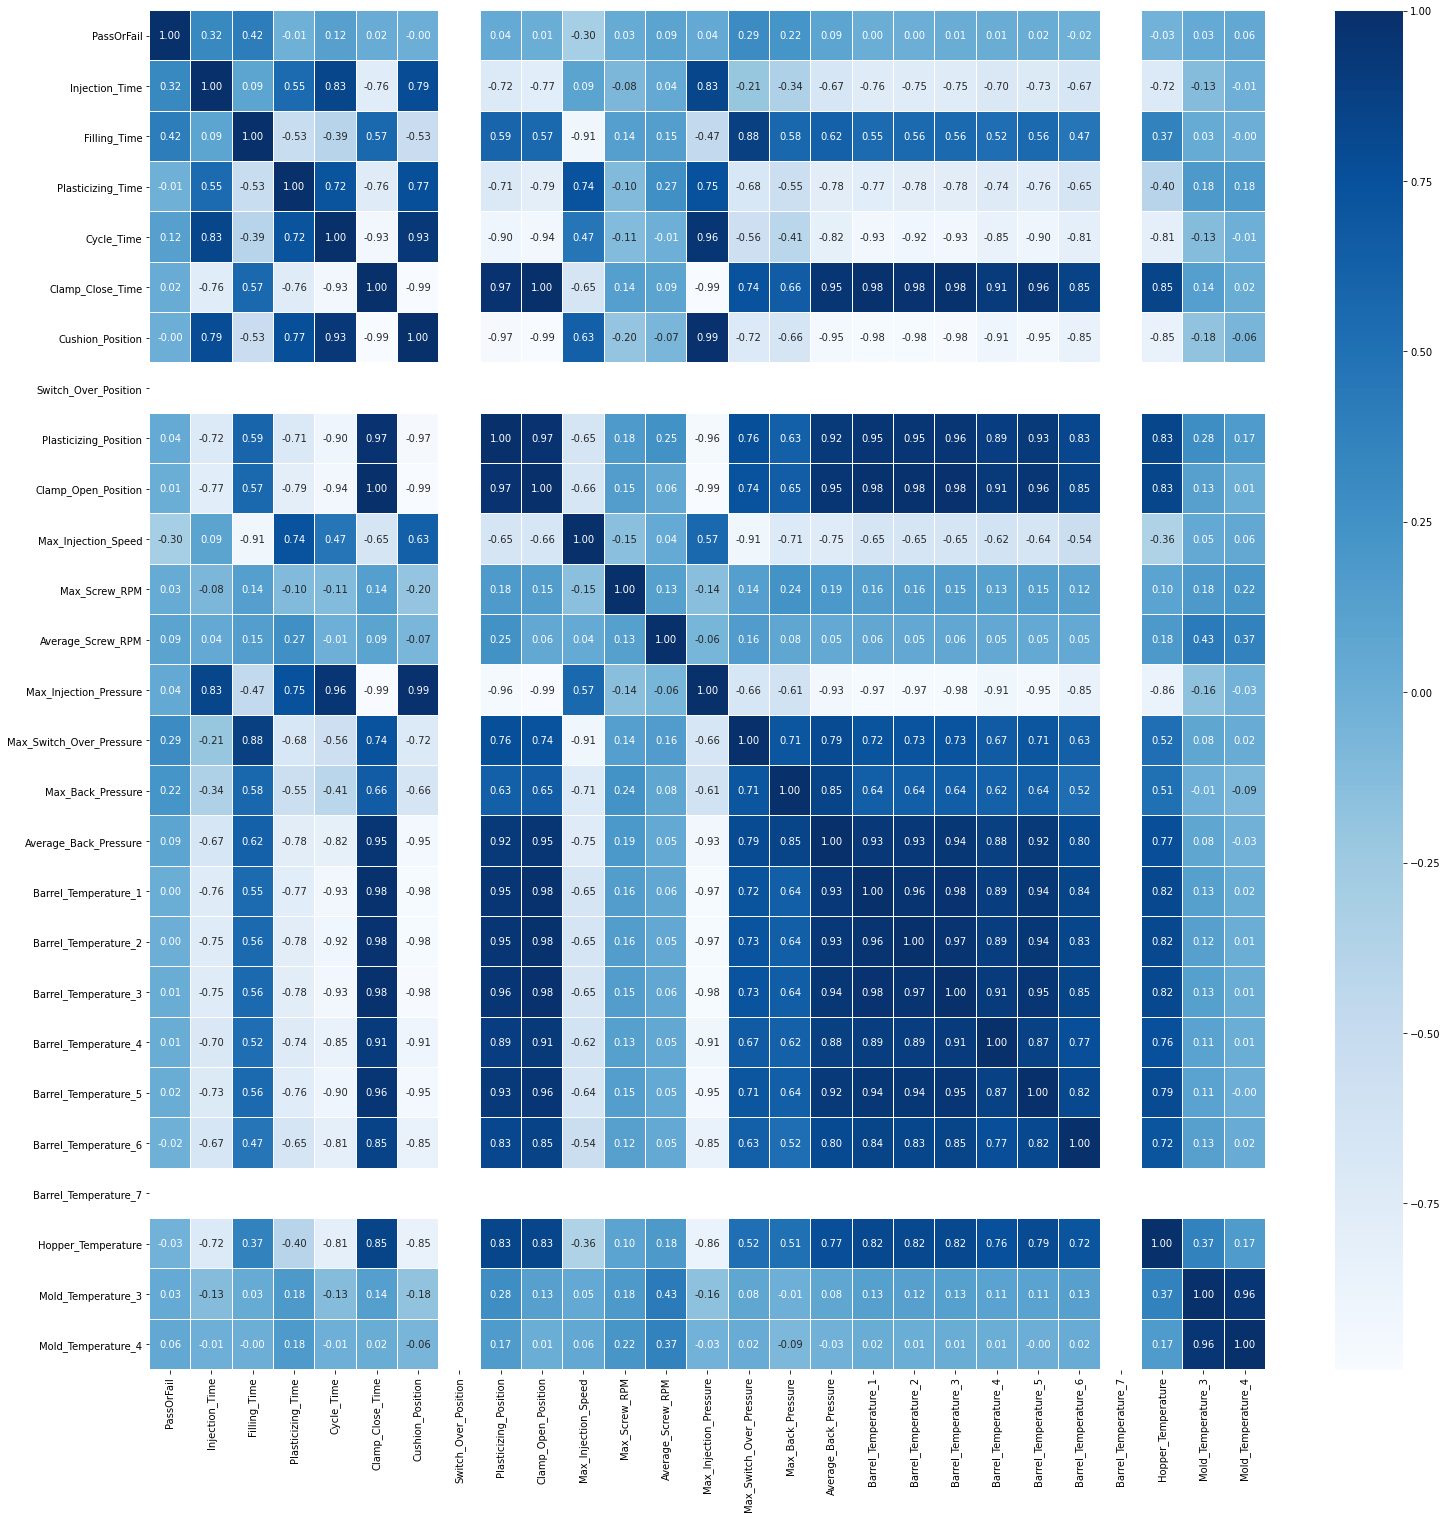

In [11]:
import seaborn as sns
plt.subplots(figsize=(25, 25))
sns.heatmap(data = cn7.corr(), linewidths=0.1, annot=True, fmt='.2f', cmap='Blues')

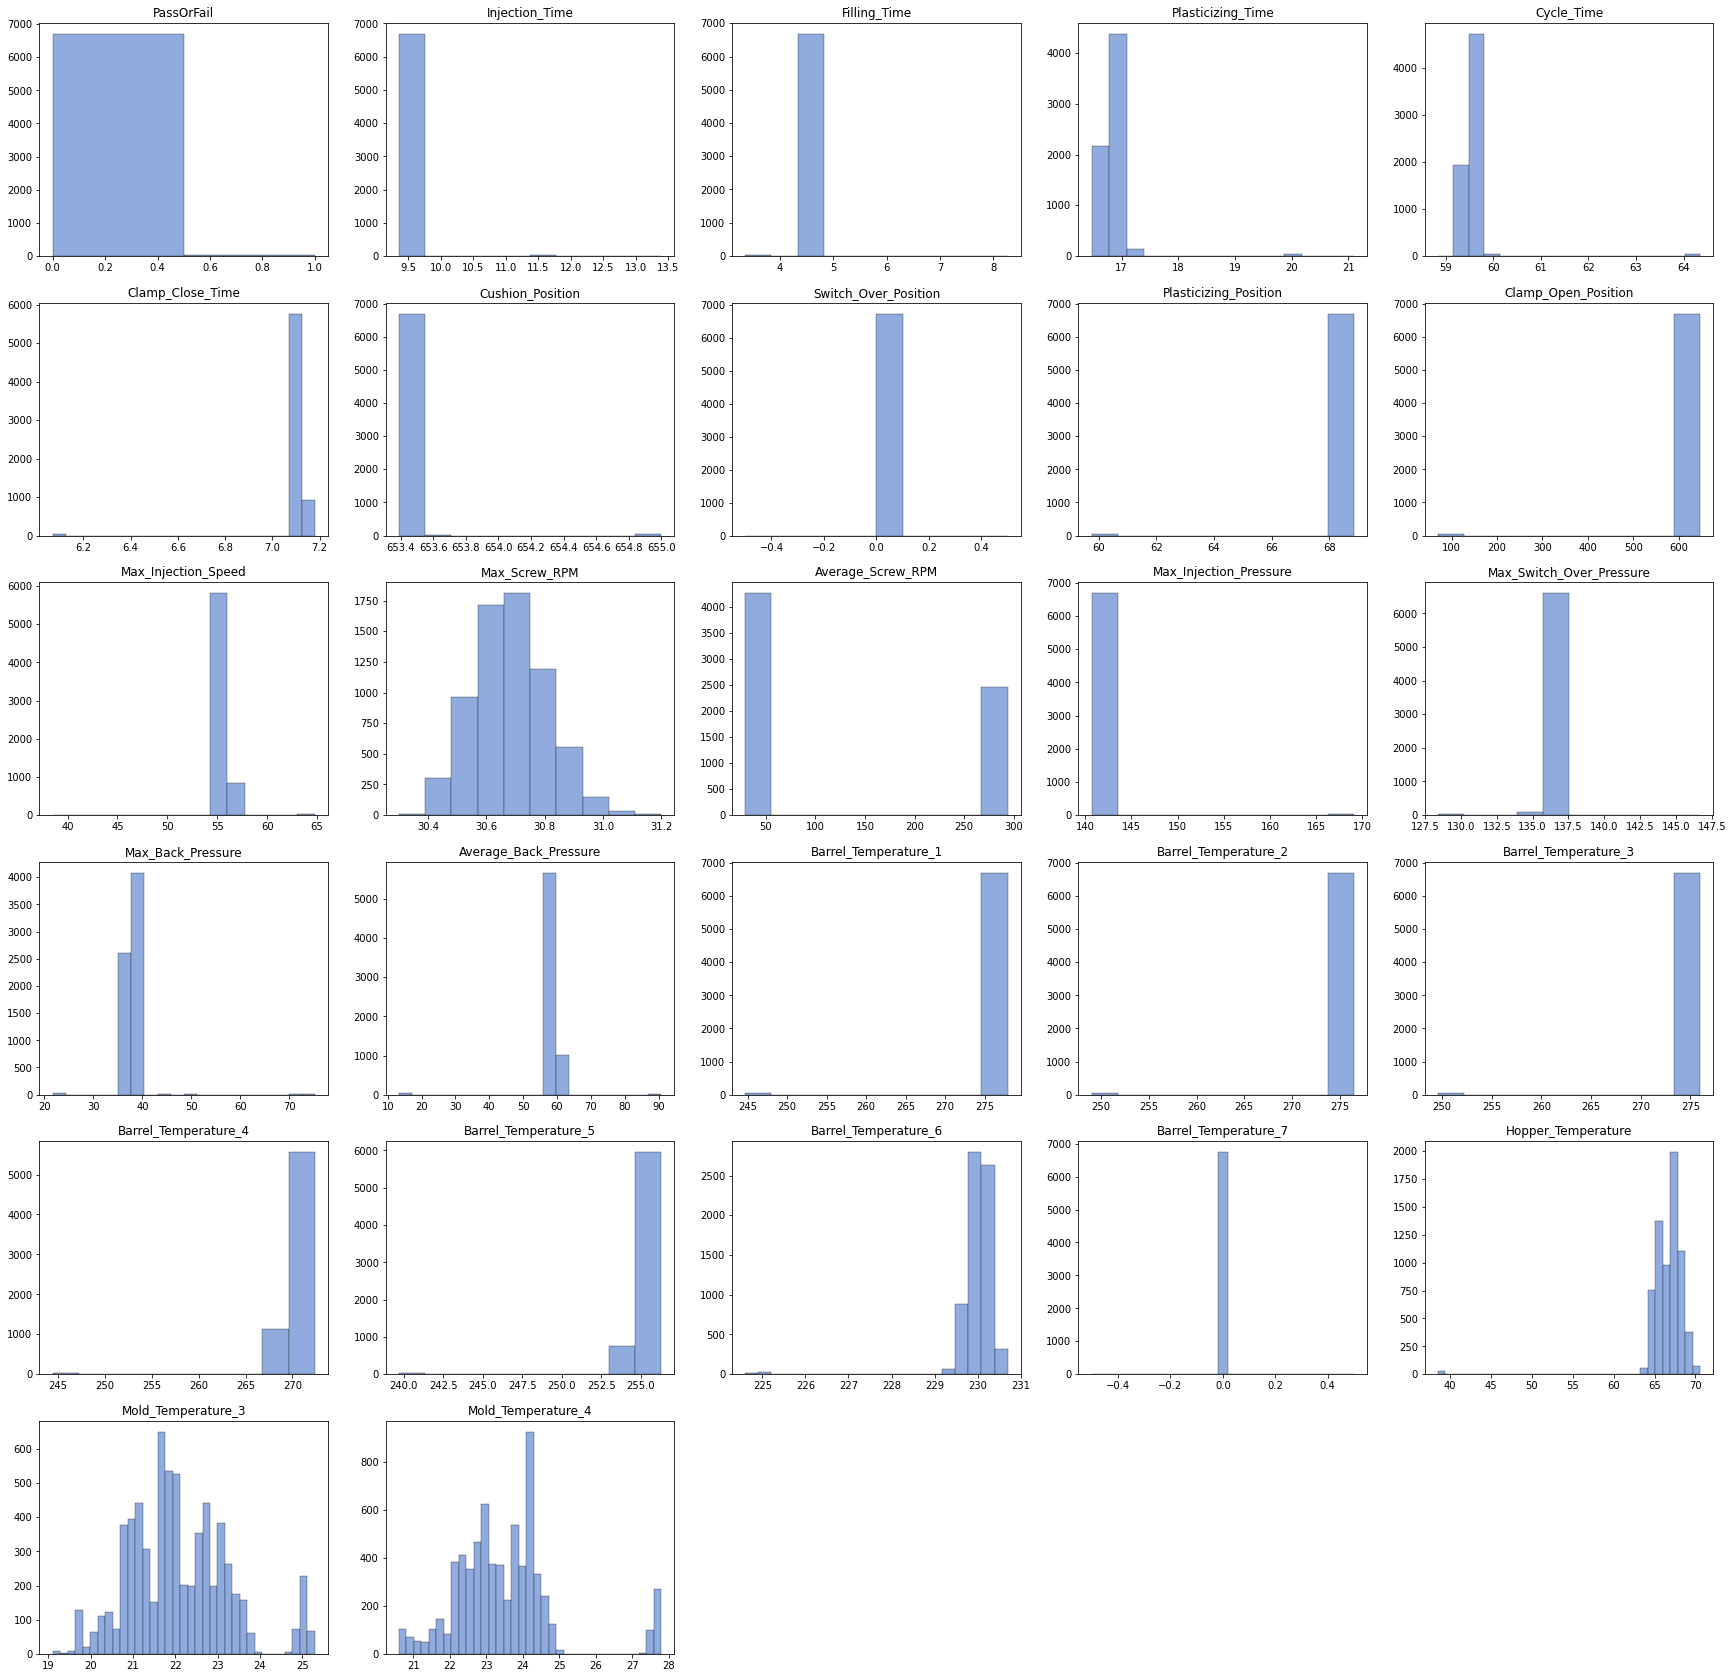

In [12]:
plt.figure(figsize=(30, 30))
bin = [2, 10, 10, 15, 17, 20, 10, 10, 10, 10, 15, 10, 10, 10, 10, 20, 20, 10, 10, 10, 10, 10, 20, 25, 35, 35, 35]

for index, value in enumerate(cn7):
    sub = plt.subplot(6, 5, index + 1)
    sub.hist(cn7[value], bins=bin[index], facecolor=(144/255, 171/255, 221/255), linewidth=.3, edgecolor='black')
    plt.title(value)

In [13]:
cn7['PassOrFail'].value_counts()

0    6697
1      39
Name: PassOrFail, dtype: int64

In [14]:
cn7_Y = cn7[cn7['PassOrFail'] == 0]
print('CN7의 양품 개수:', len(cn7_Y))

cn7_N = cn7[cn7['PassOrFail'] == 1]
print('CN7의 불량 개수:', len(cn7_Y))

CN7의 양품 개수: 6697
CN7의 불량 개수: 6697


In [15]:
cn7_Y.drop(['PassOrFail'], axis=1, inplace=True)
cn7_N.drop(['PassOrFail'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
scaler = MinMaxScaler()
cn7_Y = scaler.fit_transform(cn7_Y)
cn7_N = scaler.fit_transform(cn7_N)

In [17]:
cn7_train_Y = cn7_Y[:4000]
cn7_test_Y = cn7_Y[4000:]
cn7_test_N = cn7_N

print('CN7의 양품 학습 데이터셋 개수:', len(cn7_train_Y))
print('CN7의 평가 학습 데이터셋 개수:', len(cn7_test_Y))
print('CN7의 불량 학습 데이터셋 개수:', len(cn7_test_N))

CN7의 양품 학습 데이터셋 개수: 4000
CN7의 평가 학습 데이터셋 개수: 2697
CN7의 불량 학습 데이터셋 개수: 39


In [18]:
dropout_encoder = Sequential([
    Dropout(0.3),
    Dense(15, activation='relu'),
    Dense(5, activation='relu')
])

dropout_decoder = Sequential([
    Dense(15, activation='relu', input_shape=[5]),
    Dense(cn7_train_Y.shape[1], activation='relu')
])

dropout_AE = Sequential([dropout_encoder, dropout_decoder])

In [19]:
dropout_AE.compile(loss='mse', optimizer=Adam(lr=0.01), metrics=['accuracy'])
history = dropout_AE.fit(cn7_train_Y, cn7_train_Y, batch_size=30, epochs=30, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=7, mode='min')])

Epoch 1/30
107/107 [==============================] - 1s 6ms/step - loss: 0.1610 - accuracy: 0.0014 - val_loss: 0.0938 - val_accuracy: 0.0100
Epoch 2/30
107/107 [==============================] - 0s 2ms/step - loss: 0.0917 - accuracy: 0.0031 - val_loss: 0.0916 - val_accuracy: 0.0100
Epoch 3/30
107/107 [==============================] - 0s 2ms/step - loss: 0.0898 - accuracy: 0.0013 - val_loss: 0.0898 - val_accuracy: 0.0000e+00
Epoch 4/30
107/107 [==============================] - 0s 2ms/step - loss: 0.0894 - accuracy: 9.5803e-04 - val_loss: 0.0917 - val_accuracy: 0.0100
Epoch 5/30
107/107 [==============================] - 0s 2ms/step - loss: 0.0889 - accuracy: 0.0031 - val_loss: 0.0891 - val_accuracy: 0.0000e+00
Epoch 6/30
107/107 [==============================] - 0s 2ms/step - loss: 0.0892 - accuracy: 0.0021 - val_loss: 0.0910 - val_accuracy: 0.0100
Epoch 7/30
107/107 [==============================] - 0s 2ms/step - loss: 0.0895 - accuracy: 7.0124e-04 - val_loss: 0.0909 - val_accurac

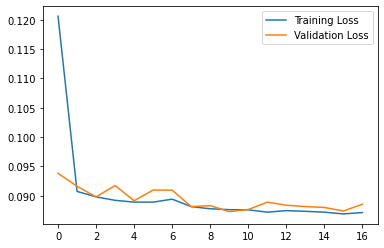

In [20]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

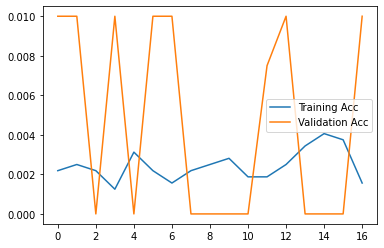

In [21]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.legend()
plt.show()

In [22]:
cn7_train_pred = dropout_AE.predict(cn7_train_Y)
cn7_train_loss = np.mean(np.square(cn7_train_pred - cn7_train_Y), axis=1)

threshold = np.mean(cn7_train_loss) + 5 * np.std(cn7_train_loss)

print('복원 오류 임계치: ', threshold)

복원 오류 임계치:  0.12264741704810544


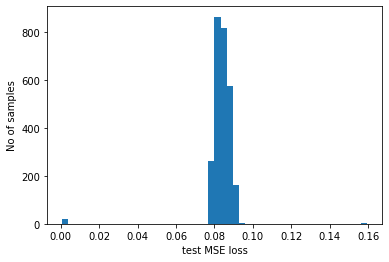

불량 개수:  2


In [23]:
cn7_predict_Y = dropout_AE.predict(cn7_test_Y)

cn7_test_Y_mse = np.mean(np.square(cn7_predict_Y - cn7_test_Y), axis=1)

plt.hist(cn7_test_Y_mse, bins=50)
plt.xlabel('test MSE loss')
plt.ylabel('No of samples')
plt.show()

cv7_test_Y_anomalies = cn7_test_Y_mse > threshold
print('불량 개수: ', np.sum(cv7_test_Y_anomalies))

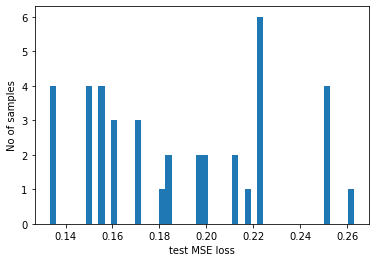

불량 개수:  39


In [24]:
cn7_predict_N = dropout_AE.predict(cn7_test_N)

cn7_test_N_mse = np.mean(np.square(cn7_predict_N - cn7_test_N), axis=1)

plt.hist(cn7_test_N_mse, bins=50)
plt.xlabel('test MSE loss')
plt.ylabel('No of samples')
plt.show()

cv7_test_N_anomalies = cn7_test_N_mse > threshold
print('불량 개수: ', np.sum(cv7_test_N_anomalies))

In [25]:
cn7_true = np.concatenate([np.zeros(len(cv7_test_Y_anomalies)), np.ones(len(cv7_test_N_anomalies))])

In [26]:
cn7_prediction = np.concatenate([cv7_test_Y_anomalies, cv7_test_N_anomalies])

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(cn7_true, cn7_prediction)

array([[2695,    2],
       [   0,   39]])

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('정확도:', accuracy_score(cn7_true, cn7_prediction))
print('정밀도:', precision_score(cn7_true, cn7_prediction))
print('재현율:', recall_score(cn7_true, cn7_prediction))
print('F1:', f1_score(cn7_true, cn7_prediction))

정확도: 0.9992690058479532
정밀도: 0.9512195121951219
재현율: 1.0
F1: 0.975
